## 딥러닝 모델 평가

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# google drive mount
!rm -r training_data validation_data test_data
!cp '/content/drive/My Drive/cnn-model/*.h5' .
!ls -l

In [1]:
%matplotlib inline
%tensorflow_version 1.x

In [2]:
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img
from tensorflow.keras.models import load_model
import model_evaluation_utils as meu

In [3]:
# pip install tensorflow==1.15
basic_cnn = load_model('cats_dogs_basic_cnn.h5')
img_aug_cnn = load_model('cats_dogs_cnn_img_aug.h5')
tl_cnn = load_model('cats_dogs_tlearn_basic_cnn.h5')
tl_img_aug_cnn = load_model('cats_dogs_tlearn_img_aug_cnn.h5')
tl_img_aug_finetune_cnn = load_model('cats_dogs_tlearn_finetune_img_aug_cnn.h5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [4]:
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
import tensorflow.keras

IMG_DIM = (150, 150)
input_shape = (150, 150, 3)
num2class_label_transformer = lambda l: ['cat' if x == 0 else 'dog' for x in l]
class2num_label_transformer = lambda l: [0 if x == 'cat' else 1 for x in l]


vgg = vgg16.VGG16(include_top=False, weights='imagenet', 
                  input_shape=input_shape)
output = vgg.layers[-1].output
output = tensorflow.keras.layers.Flatten()(output)
vgg_model = Model(vgg.input, output)
vgg_model.trainable = False

def get_bottleneck_features(model, input_imgs):    
    features = model.predict(input_imgs, verbose=0)
    return features

In [5]:
sample_img_path = 'my_cat-2.jpg'
sample_img = load_img(sample_img_path, target_size=IMG_DIM)
sample_img_tensor = img_to_array(sample_img)
sample_img_tensor = np.expand_dims(sample_img_tensor, axis=0)
sample_img_tensor /= 255.

print(sample_img_tensor.shape)

(1, 150, 150, 3)


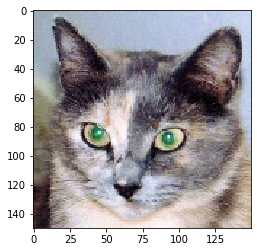

In [6]:
plt.imshow(sample_img_tensor[0])

In [7]:
cnn_prediction = num2class_label_transformer(basic_cnn.predict_classes(sample_img_tensor, verbose=0))
cnn_img_aug_prediction = num2class_label_transformer(img_aug_cnn.predict_classes(sample_img_tensor, verbose=0))
tlearn_cnn_prediction = num2class_label_transformer(tl_cnn.predict_classes(get_bottleneck_features(vgg_model, 
                                                                                                    sample_img_tensor), 
                                                                            verbose=0))
tlearn_cnn_img_aug_prediction = num2class_label_transformer(tl_img_aug_cnn.predict_classes(sample_img_tensor, verbose=0))
tlearn_cnn_finetune_img_aug_prediction = num2class_label_transformer(tl_img_aug_finetune_cnn.predict_classes(sample_img_tensor, 
                                                                                                         verbose=0))

print('Predictions for our sample image:\n', 
      '\nBasic CNN:', cnn_prediction, 
      '\nCNN with Img Augmentation:', cnn_img_aug_prediction, 
      '\nPre-trained CNN (Transfer Learning):', tlearn_cnn_prediction,
      '\nPre-trained CNN with Img Augmentation (Transfer Learning):', tlearn_cnn_img_aug_prediction, 
      '\nPre-trained CNN with Fine-tuning & Img Augmentation (Transfer Learning):', tlearn_cnn_finetune_img_aug_prediction)

Predictions for our sample image:
 
Basic CNN: ['dog'] 
CNN with Img Augmentation: ['cat'] 
Pre-trained CNN (Transfer Learning): ['cat'] 
Pre-trained CNN with Img Augmentation (Transfer Learning): ['cat'] 
Pre-trained CNN with Fine-tuning & Img Augmentation (Transfer Learning): ['cat']


In [8]:
IMG_DIM = (150, 150)

test_files = glob.glob('test_data/*')
test_imgs = [img_to_array(load_img(img, target_size=IMG_DIM)) for img in test_files]
test_imgs = np.array(test_imgs)
# test_labels = [fn.split('/')[1].split('.')[0].strip() for fn in test_files]  # for Linux
test_labels = [fn.split('\\')[1].split('.')[0].strip() for fn in test_files]  # for Windows

print('Test dataset shape:', test_imgs.shape)

Test dataset shape: (1000, 150, 150, 3)


In [9]:
test_imgs_scaled = test_imgs.astype('float32')
test_imgs_scaled /= 255

test_labels_enc = class2num_label_transformer(test_labels)

print(test_labels[0:5], test_labels_enc[0:5])

['cat', 'cat', 'cat', 'cat', 'cat'] [0, 0, 0, 0, 0]


In [10]:
predictions = basic_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)

meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.751
Precision: 0.7522
Recall: 0.751
F1 Score: 0.7507

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.73      0.79      0.76       500
         cat       0.77      0.72      0.74       500

    accuracy                           0.75      1000
   macro avg       0.75      0.75      0.75      1000
weighted avg       0.75      0.75      0.75      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   dog  cat
Actual: dog        393  107
        cat        142  358


C:\share\ai-model\lab_ok\ch3.TransferLearning\model_evaluation_utils.py:62: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels),
C:\share\ai-model\lab_ok\ch3.TransferLearning\model_evaluation_utils.py:64: FutureWarning: the 'labels' keyword is deprecated, use 'codes' instead
  labels=level_labels))


In [11]:
predictions = img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)

meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.793
Precision: 0.8175
Recall: 0.793
F1 Score: 0.7889

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.91      0.65      0.76       500
         cat       0.73      0.93      0.82       500

    accuracy                           0.79      1000
   macro avg       0.82      0.79      0.79      1000
weighted avg       0.82      0.79      0.79      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   dog  cat
Actual: dog        327  173
        cat         34  466


In [12]:
test_bottleneck_features = get_bottleneck_features(vgg_model, test_imgs_scaled)

predictions = tl_cnn.predict_classes(test_bottleneck_features, verbose=0)
predictions = num2class_label_transformer(predictions)

meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.895
Precision: 0.8952
Recall: 0.895
F1 Score: 0.895

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.89      0.91      0.90       500
         cat       0.90      0.88      0.89       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.89      1000
weighted avg       0.90      0.90      0.89      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   dog  cat
Actual: dog        453   47
        cat         58  442


In [13]:
predictions = tl_img_aug_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)

meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.902
Precision: 0.902
Recall: 0.902
F1 Score: 0.902

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.90      0.91      0.90       500
         cat       0.91      0.90      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   dog  cat
Actual: dog        453   47
        cat         51  449


In [14]:
predictions = tl_img_aug_finetune_cnn.predict_classes(test_imgs_scaled, verbose=0)
predictions = num2class_label_transformer(predictions)

meu.display_model_performance_metrics(true_labels=test_labels, predicted_labels=predictions, 
                                      classes=list(set(test_labels)))

Model Performance metrics:
------------------------------
Accuracy: 0.959
Precision: 0.9591
Recall: 0.959
F1 Score: 0.959

Model Classification report:
------------------------------
              precision    recall  f1-score   support

         dog       0.95      0.97      0.96       500
         cat       0.97      0.95      0.96       500

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000


Prediction Confusion Matrix:
------------------------------
            Predicted:     
                   dog  cat
Actual: dog        484   16
        cat         25  475


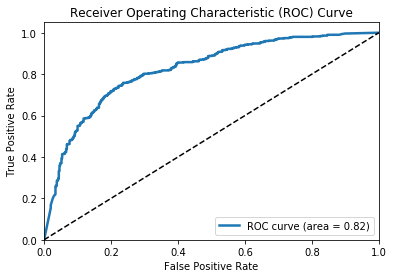

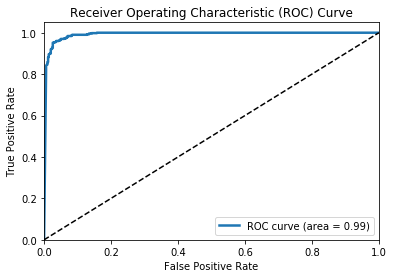

In [15]:
meu.plot_model_roc_curve(basic_cnn, test_imgs_scaled, 
                                  true_labels=test_labels_enc, class_names=[0, 1])

meu.plot_model_roc_curve(tl_img_aug_finetune_cnn, test_imgs_scaled, 
                                  true_labels=test_labels_enc, class_names=[0, 1])